# Install required packages

In [1]:
!pip install networkx javalang

# Create a graph representation of the software system

In [2]:
import javalang

def parse_java_file(file_path):
    with open(file_path, 'rb') as file:
        file_content = file.read()
    return javalang.parse.parse(file_content)

In [3]:
import os
import networkx as nx
import matplotlib.pyplot as plt

def build_graph_representation(directory):
    graph = nx.MultiDiGraph()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".java"):
                #print('file: ', file)
                file_path = os.path.join(root, file)
                tree = parse_java_file(file_path)
                add_nodes_and_edges(tree, graph)

    remove_redundant_nodes(graph)     
    
    return graph

def find_declaring_class_of_qualifer(tree, target_qualifer):
    result = ""
    for path, node in tree.filter(javalang.tree.ClassDeclaration):
        for field in node.fields:
            if field.declarators[0].name == target_qualifer:
              result = field.type.name
              break
        
    return result

PRIMITIVE_TYPES = {"int", "float", "double", "char", "byte", "short", "long", "boolean"}
STANDARD_JAVA_CLASSES = {"String", "Integer", "Float", "Double", "Character", "Byte", "Short", "Long", "Boolean"}

def is_valid_class(class_name):
    return class_name not in PRIMITIVE_TYPES and class_name not in STANDARD_JAVA_CLASSES

def get_package_name(tree):
    for path, node in tree.filter(javalang.tree.PackageDeclaration):
        return node.name
    return ""

def get_full_class_name(package_name, class_name):
    return package_name + "." + class_name

def get_node_type(node):
    if isinstance(node, javalang.tree.ClassDeclaration):
        if "abstract" in node.modifiers:
            return "A"
        elif node.type_parameters is not None:
            return "T"
        else:
            return "C"
    elif isinstance(node, javalang.tree.InterfaceDeclaration):
        return "I"

def add_node(graph, node_name, class_type):
    if is_valid_class(node_name):
      graph.add_node(node_name, class_type=class_type, weight=1)

def add_nodes(tree, graph):
    package_name = get_package_name(tree)
    for path, node in tree.filter(javalang.tree.ClassDeclaration):
      class_name = get_full_class_name(package_name, node.name)
      class_type = get_node_type(node)
      add_node(graph, node.name, class_type)

    for path, node in tree.filter(javalang.tree.InterfaceDeclaration):
      class_name = get_full_class_name(package_name, node.name)
      class_type = get_node_type(node)
      add_node(graph, node.name, class_type)

def add_edge(graph, source, target, edge_type):
    graph.add_edge(source, target, edge_type=edge_type, weight=1)

def add_edges(tree, graph):
    for path, node in tree.filter(javalang.tree.ClassDeclaration):
      # Inheritance
      if node.extends:
        for parent in node.extends:
          if type(parent) is tuple and len(parent) > 1:
            if hasattr(parent[1], 'name'):
              add_edge(graph, node.name, parent[1].name, "X")
            else:
              add_edge(graph, node.name, parent.name, "X")
            
      # Implements
      if node.implements:
        for interface in node.implements:
          add_edge(graph, node.name, interface.name, "I")

      # Field types (A)
      for field in node.fields:
        field_type = field.type.name
        if field_type not in graph:
          add_node(graph, field_type, "C")
        add_edge(graph, node.name, field_type, "A")

      # Method calls (M), field access (F), and other relationships
      for _, method in node.filter(javalang.tree.MethodDeclaration):
          for _, method_invocation in method.filter(javalang.tree.MethodInvocation):
              if method_invocation.qualifier:
                  declaring_class_name = find_declaring_class_of_qualifer(tree, method_invocation.qualifier)
                  if declaring_class_name != "":
                    add_edge(graph, node.name, declaring_class_name, "M")

          for _, field_reference in method.filter(javalang.tree.MemberReference):
              if field_reference.qualifier:
                  add_edge(graph, node.name, field_reference.qualifier, "F")

          for _, local_var in method.filter(javalang.tree.LocalVariableDeclaration):
              add_edge(graph, node.name, local_var.type.name, "L")

          for param in method.parameters:
            add_edge(graph, node.name, param.type.name, "P")
            if method.return_type:
                add_edge(graph, node.name, method.return_type.name, "R")
        
      # Object creation (C)
      for _, object_creation in node.filter(javalang.tree.ClassCreator):
          add_edge(graph, node.name, object_creation.type.name, "C")

      # Override (O)
      for _, method in node.filter(javalang.tree.MethodDeclaration):
          if any("Override" in annotation.name for annotation in method.annotations):
              add_edge(graph, node.name, method.name, "O")

def add_nodes_and_edges(tree, graph):
    # Add nodes
    add_nodes(tree, graph)

    # Add edges
    add_edges(tree, graph)

def should_remove_node(node, data):
    return not data  

def remove_redundant_nodes(graph):
    # Get the list of nodes to remove
    nodes_to_remove = [node for node, data in graph.nodes(data=True) if should_remove_node(node, data)]

    # Remove the nodes from the graph
    for node in nodes_to_remove:
        if node in graph:
          graph.remove_node(node)

Node: A
Edges:
  A --(X)--> B
  A --(A)--> B
  A --(I)--> C

Node: B
Edges:
  B --(M)--> D

Node: C
No edges

Node: D
Edges:
  D --(P)--> C



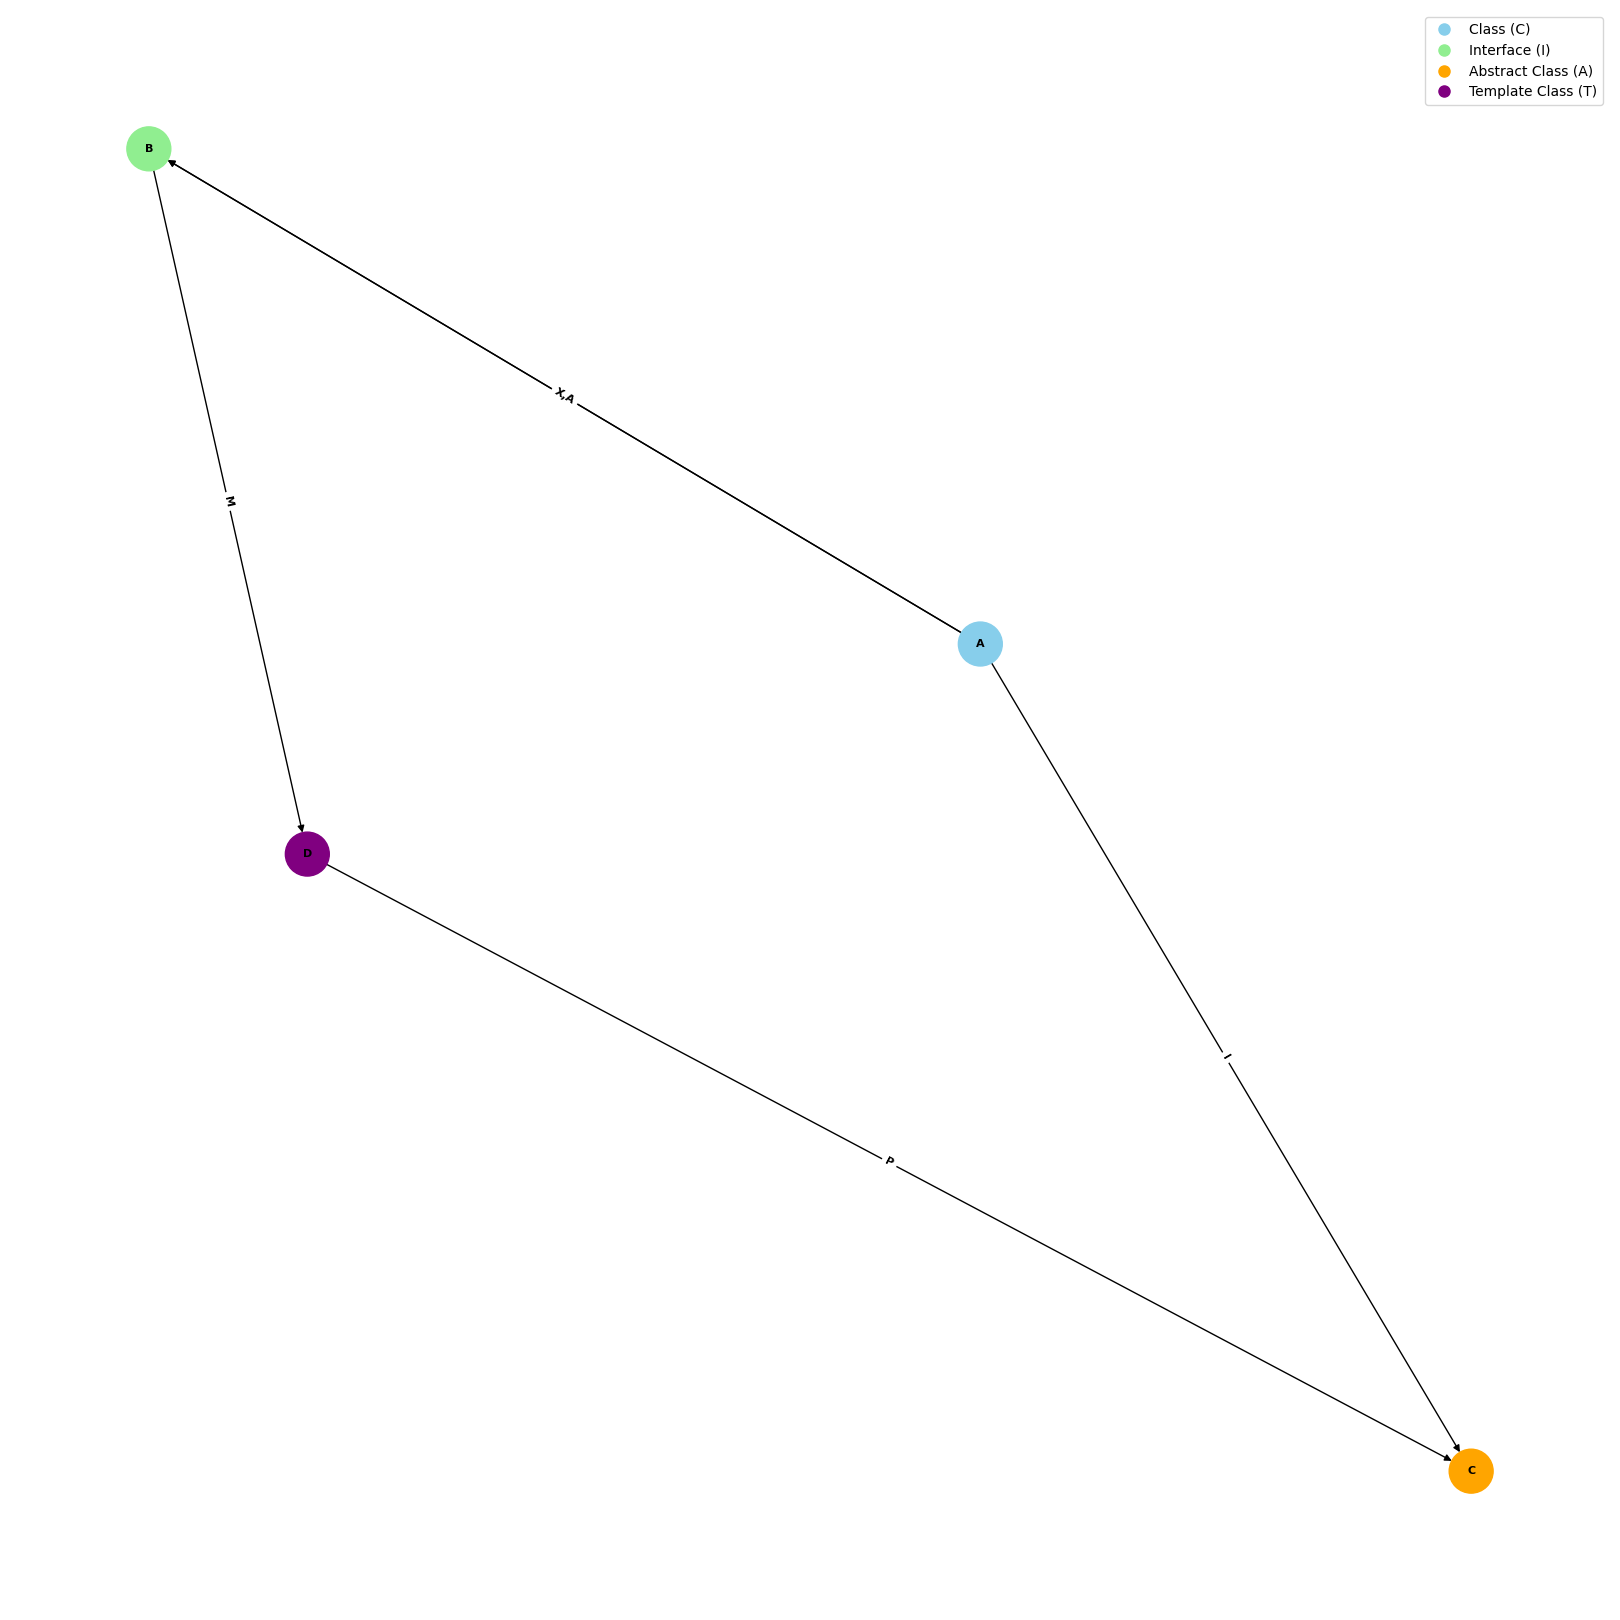

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def print_nodes_and_edges(graph):
    for node in graph.nodes:
        print(f"Node: {node}")
        edges = list(graph.edges(node, data=True))
        if edges:
            print("Edges:")
            for source, target, data in edges:
                label = data['edge_type']
                print(f"  {source} --({label})--> {target}")
        else:
            print("No edges")
        print()

def convert_multiedge_to_labels(edge_attr):
    edge_labels = {}
    for (u, v, key), label in edge_attr.items():
        if (u, v) in edge_labels.keys():
          edge_labels[(u, v)] = edge_labels[(u, v)] + "," + label
        else:
          edge_labels[(u, v)] = label
    return edge_labels

def visualize_graph(graph):
    pos = nx.spring_layout(graph, seed=42)
    plt.figure(figsize=(16, 16))

    node_colors = []
    node_labels = {}

    for node in graph.nodes:
        node_type = "Unknown"
        if graph.nodes[node]:
          node_type = graph.nodes[node]["class_type"]
        node_labels[node] = node

        if node_type == "C":
            node_colors.append("skyblue")
        elif node_type == "I":
            node_colors.append("lightgreen")
        elif node_type == "A":
            node_colors.append("orange")
        elif node_type == "T":
            node_colors.append("purple")
        else:
            node_colors.append("gray")

    nx.draw(graph, pos, labels=node_labels, node_size=1000, node_color=node_colors, font_size=8, font_weight='bold')
    
    edge_attr = nx.get_edge_attributes(graph, 'edge_type')
    edge_labels = convert_multiedge_to_labels(edge_attr)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8, font_weight="bold")
    

    # Create legend
    custom_lines = [Line2D([0], [0], marker='o', color='skyblue', label='Class (C)', markersize=8, linestyle='None'),
                    Line2D([0], [0], marker='o', color='lightgreen', label='Interface (I)', markersize=8, linestyle='None'),
                    Line2D([0], [0], marker='o', color='orange', label='Abstract Class (A)', markersize=8, linestyle='None'),
                    Line2D([0], [0], marker='o', color='purple', label='Template Class (T)', markersize=8, linestyle='None')]

    plt.legend(handles=custom_lines, loc='upper right')

    plt.show()

# Example usage
G = nx.MultiDiGraph()
G.add_node("A", class_type="C")
G.add_node("B", class_type="I")
G.add_node("C", class_type="A")
G.add_node("D", class_type="T")
G.add_edge("A", "B", edge_type="X")
G.add_edge("A", "B", edge_type="A")
G.add_edge("A", "C", edge_type="I")
G.add_edge("B", "D", edge_type="M")
G.add_edge("D", "C", edge_type="P")
print_nodes_and_edges(G)
visualize_graph(G)

Node: RowingBoat
No edges

Node: FishingBoatAdapter
Edges:
  FishingBoatAdapter --(I)--> RowingBoat
  FishingBoatAdapter --(A)--> FishingBoat
  FishingBoatAdapter --(M)--> FishingBoat
  FishingBoatAdapter --(C)--> FishingBoat

Node: FishingBoat
No edges

Node: App
Edges:
  App --(C)--> Captain
  App --(C)--> FishingBoatAdapter

Node: Captain
Edges:
  Captain --(A)--> RowingBoat
  Captain --(M)--> RowingBoat



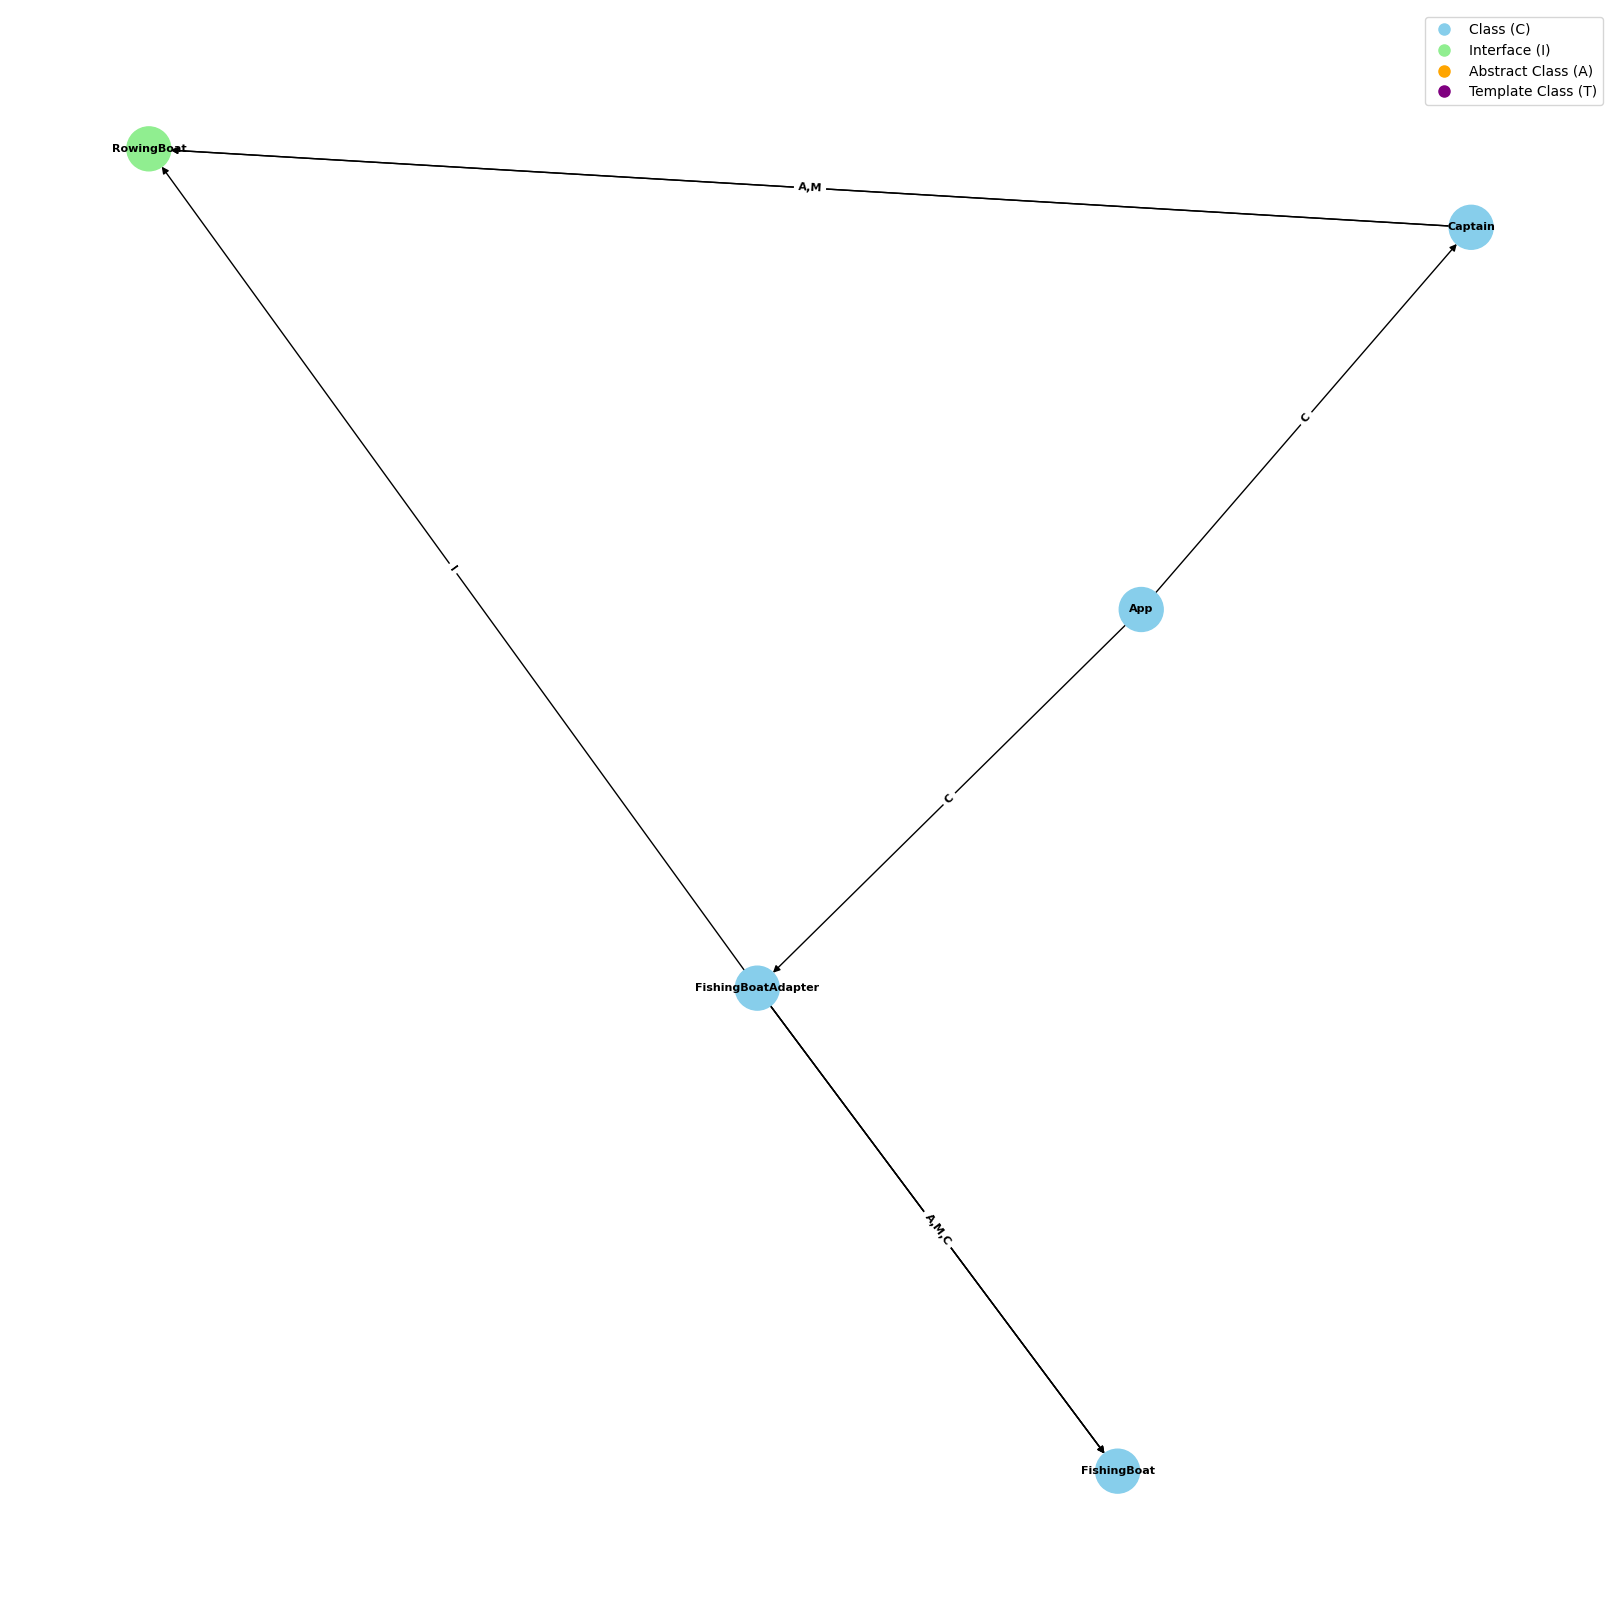

In [7]:
pattern = "adapter"
java_project_directory = "input/java-design-patterns-master/{pattern_dir}/src/main".format(pattern_dir = pattern)
class_dependency_graph = build_graph_representation(java_project_directory)
print_nodes_and_edges(class_dependency_graph)
visualize_graph(class_dependency_graph)

Node: PartyMemberBase
Edges:
  PartyMemberBase --(I)--> PartyMember
  PartyMemberBase --(A)--> Party
  PartyMemberBase --(P)--> Party
  PartyMemberBase --(M)--> Party

Node: PartyMember
No edges

Node: Party
No edges

Node: PartyImpl
Edges:
  PartyImpl --(I)--> Party
  PartyImpl --(A)--> List
  PartyImpl --(M)--> List
  PartyImpl --(P)--> PartyMember
  PartyImpl --(P)--> PartyMember

Node: List
No edges

Node: App
Edges:
  App --(L)--> Party
  App --(C)--> PartyImpl
  App --(C)--> Hobbit
  App --(C)--> Wizard
  App --(C)--> Rogue
  App --(C)--> Hunter

Node: Hobbit
Edges:
  Hobbit --(X)--> PartyMemberBase

Node: Wizard
Edges:
  Wizard --(X)--> PartyMemberBase

Node: Rogue
Edges:
  Rogue --(X)--> PartyMemberBase

Node: Hunter
Edges:
  Hunter --(X)--> PartyMemberBase



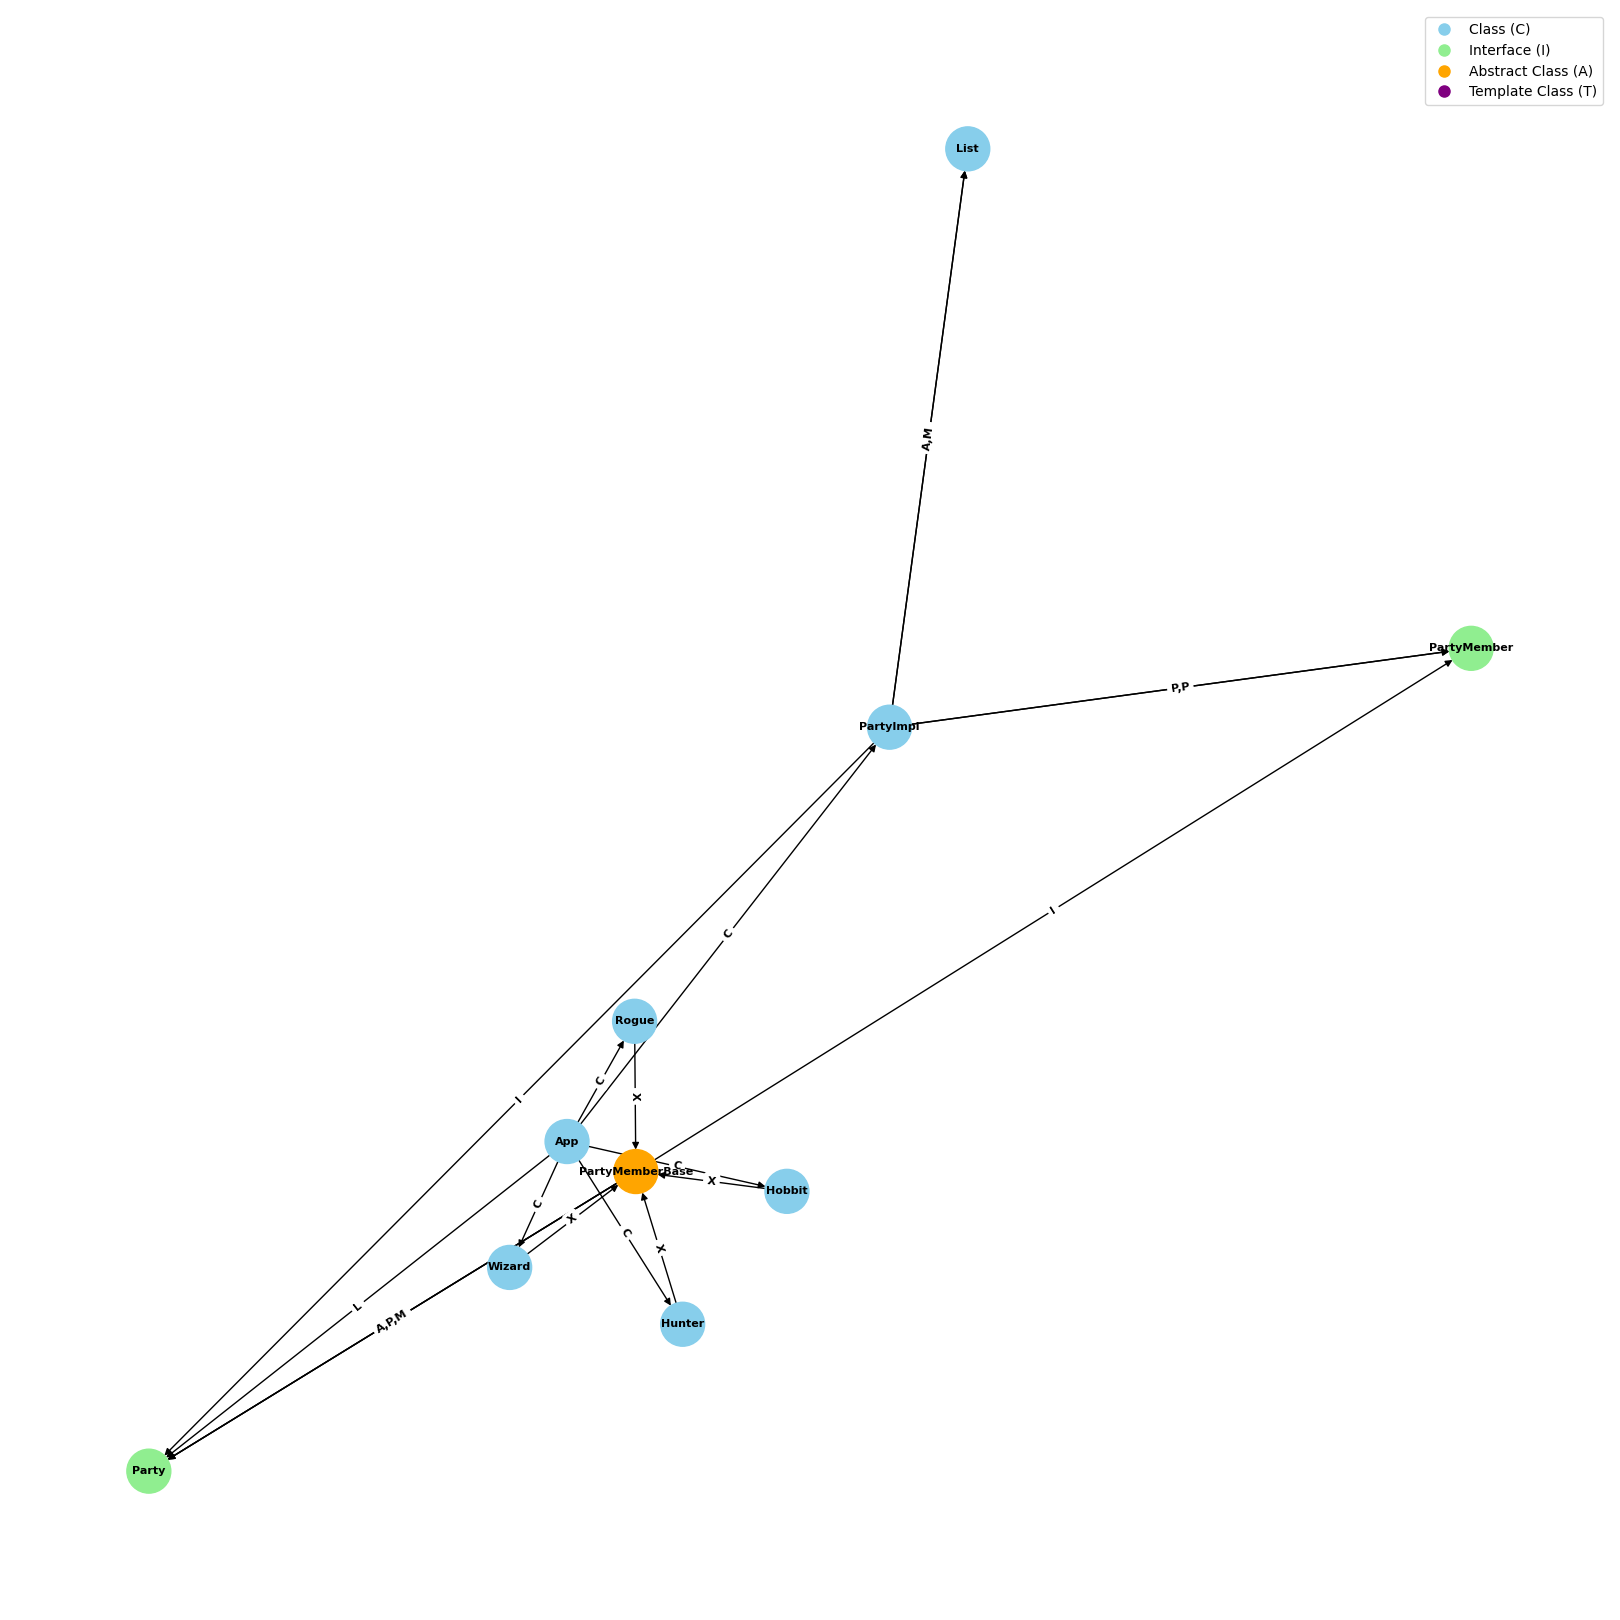

In [9]:
pattern = "mediator"
java_project_directory = "input/java-design-patterns-master/{pattern_dir}/src/main".format(pattern_dir = pattern)
class_dependency_graph = build_graph_representation(java_project_directory)
print_nodes_and_edges(class_dependency_graph)
visualize_graph(class_dependency_graph)

In [8]:
pattern = "observer"
java_project_directory = "input/java-design-patterns-master/{pattern_dir}/src/main".format(pattern_dir = pattern)
class_dependency_graph = build_graph_representation(java_project_directory)
print_nodes_and_edges(class_dependency_graph)
visualize_graph(class_dependency_graph)

AttributeError: 'tuple' object has no attribute 'name'

In [10]:
java_project_directory = "input/java-design-patterns-master/event-driven-architecture/src/main"
class_dependency_graph = build_graph_representation(java_project_directory)

In [11]:
print_nodes_and_edges(class_dependency_graph)

Node: App
Edges:
  App --(C)--> EventDispatcher
  App --(C)--> UserCreatedEventHandler
  App --(C)--> UserUpdatedEventHandler
  App --(C)--> User
  App --(C)--> UserCreatedEvent
  App --(C)--> UserUpdatedEvent

Node: EventDispatcher
Edges:
  EventDispatcher --(A)--> Map
  EventDispatcher --(M)--> Map
  EventDispatcher --(M)--> Map
  EventDispatcher --(P)--> Handler

Node: UserCreatedEventHandler
Edges:
  UserCreatedEventHandler --(I)--> Handler
  UserCreatedEventHandler --(P)--> UserCreatedEvent

Node: UserUpdatedEventHandler
Edges:
  UserUpdatedEventHandler --(I)--> Handler
  UserUpdatedEventHandler --(P)--> UserUpdatedEvent

Node: User
No edges

Node: UserCreatedEvent
Edges:
  UserCreatedEvent --(X)--> AbstractEvent
  UserCreatedEvent --(A)--> User

Node: UserUpdatedEvent
Edges:
  UserUpdatedEvent --(X)--> AbstractEvent
  UserUpdatedEvent --(A)--> User

Node: AbstractEvent
Edges:
  AbstractEvent --(I)--> Event

Node: Event
No edges

Node: Handler
No edges

Node: Map
No edges



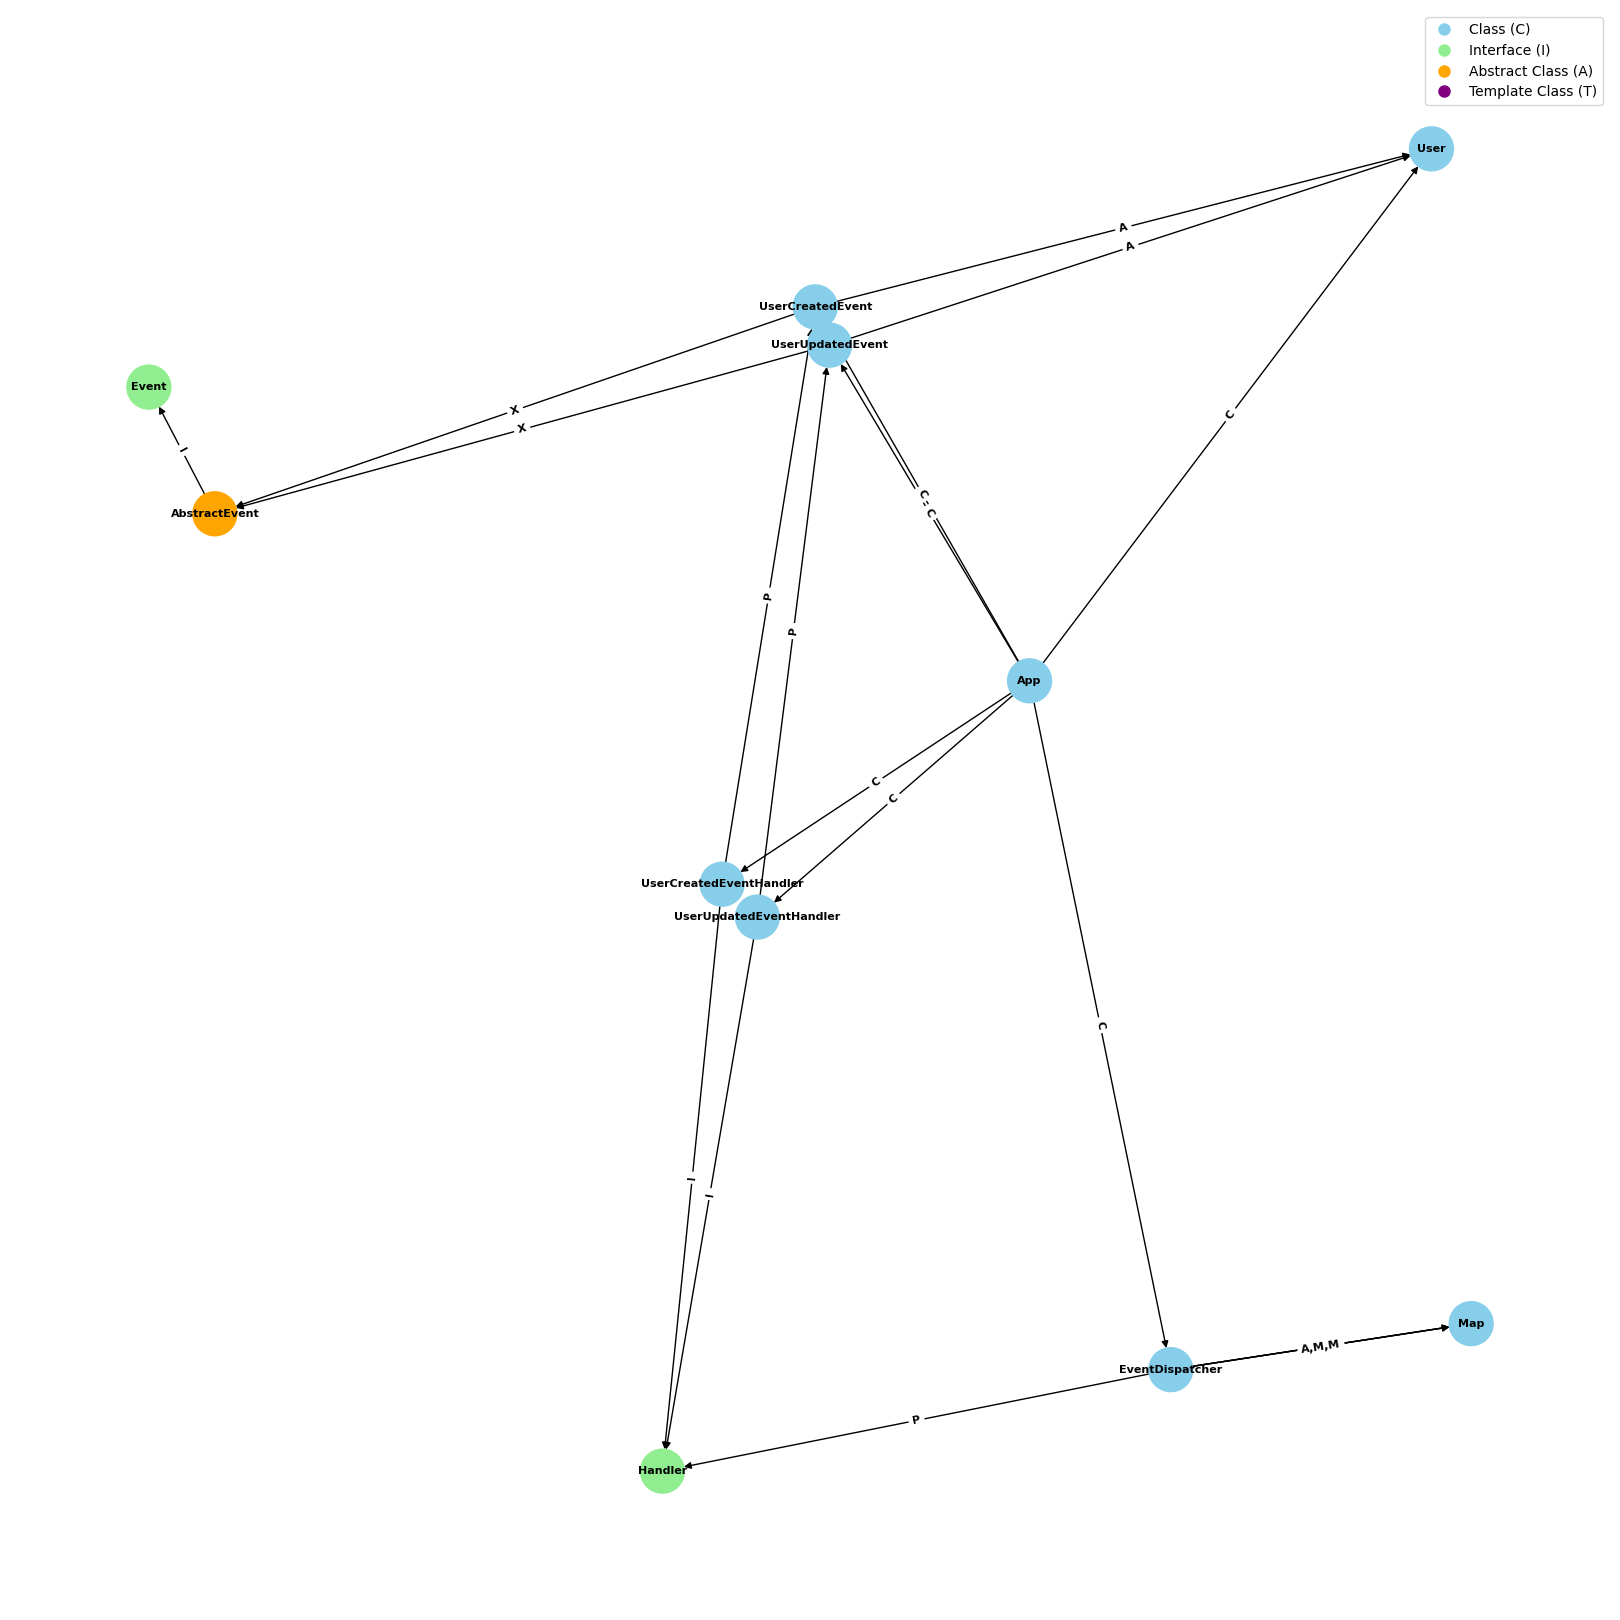

In [12]:
visualize_graph(class_dependency_graph)

In [ ]:
java_project_directory = "/content/drive/MyDrive/Colab Notebooks/input/argouml-master/src"
class_dependency_graph = build_graph_representation(java_project_directory)

In [ ]:
print_nodes_and_edges(class_dependency_graph)

Streaming output truncated to the last 5000 lines.
  UMLClassifierParameterListModel --(X)--> UMLModelElementListModel
  UMLClassifierParameterListModel --(I)--> Ordered

Node: UMLCollaborationRepresentedOperationComboBoxModel
Edges:
  UMLCollaborationRepresentedOperationComboBoxModel --(X)--> UMLComboBoxModel
  UMLCollaborationRepresentedOperationComboBoxModel --(L)--> Project
  UMLCollaborationRepresentedOperationComboBoxModel --(R)--> Action
  UMLCollaborationRepresentedOperationComboBoxModel --(L)--> UMLComboBox
  UMLCollaborationRepresentedOperationComboBoxModel --(C)--> ArrayList
  UMLCollaborationRepresentedOperationComboBoxModel --(C)--> ActionSetRepresentedOperationCollaboration

Node: ActionSetRepresentedOperationCollaboration
Edges:
  ActionSetRepresentedOperationCollaboration --(X)--> UndoableAction
  ActionSetRepresentedOperationCollaboration --(L)--> UMLComboBox

Node: SingleListFactory
Edges:
  SingleListFactory --(I)--> ComponentFactory
  SingleListFactory --(L)--> Defa

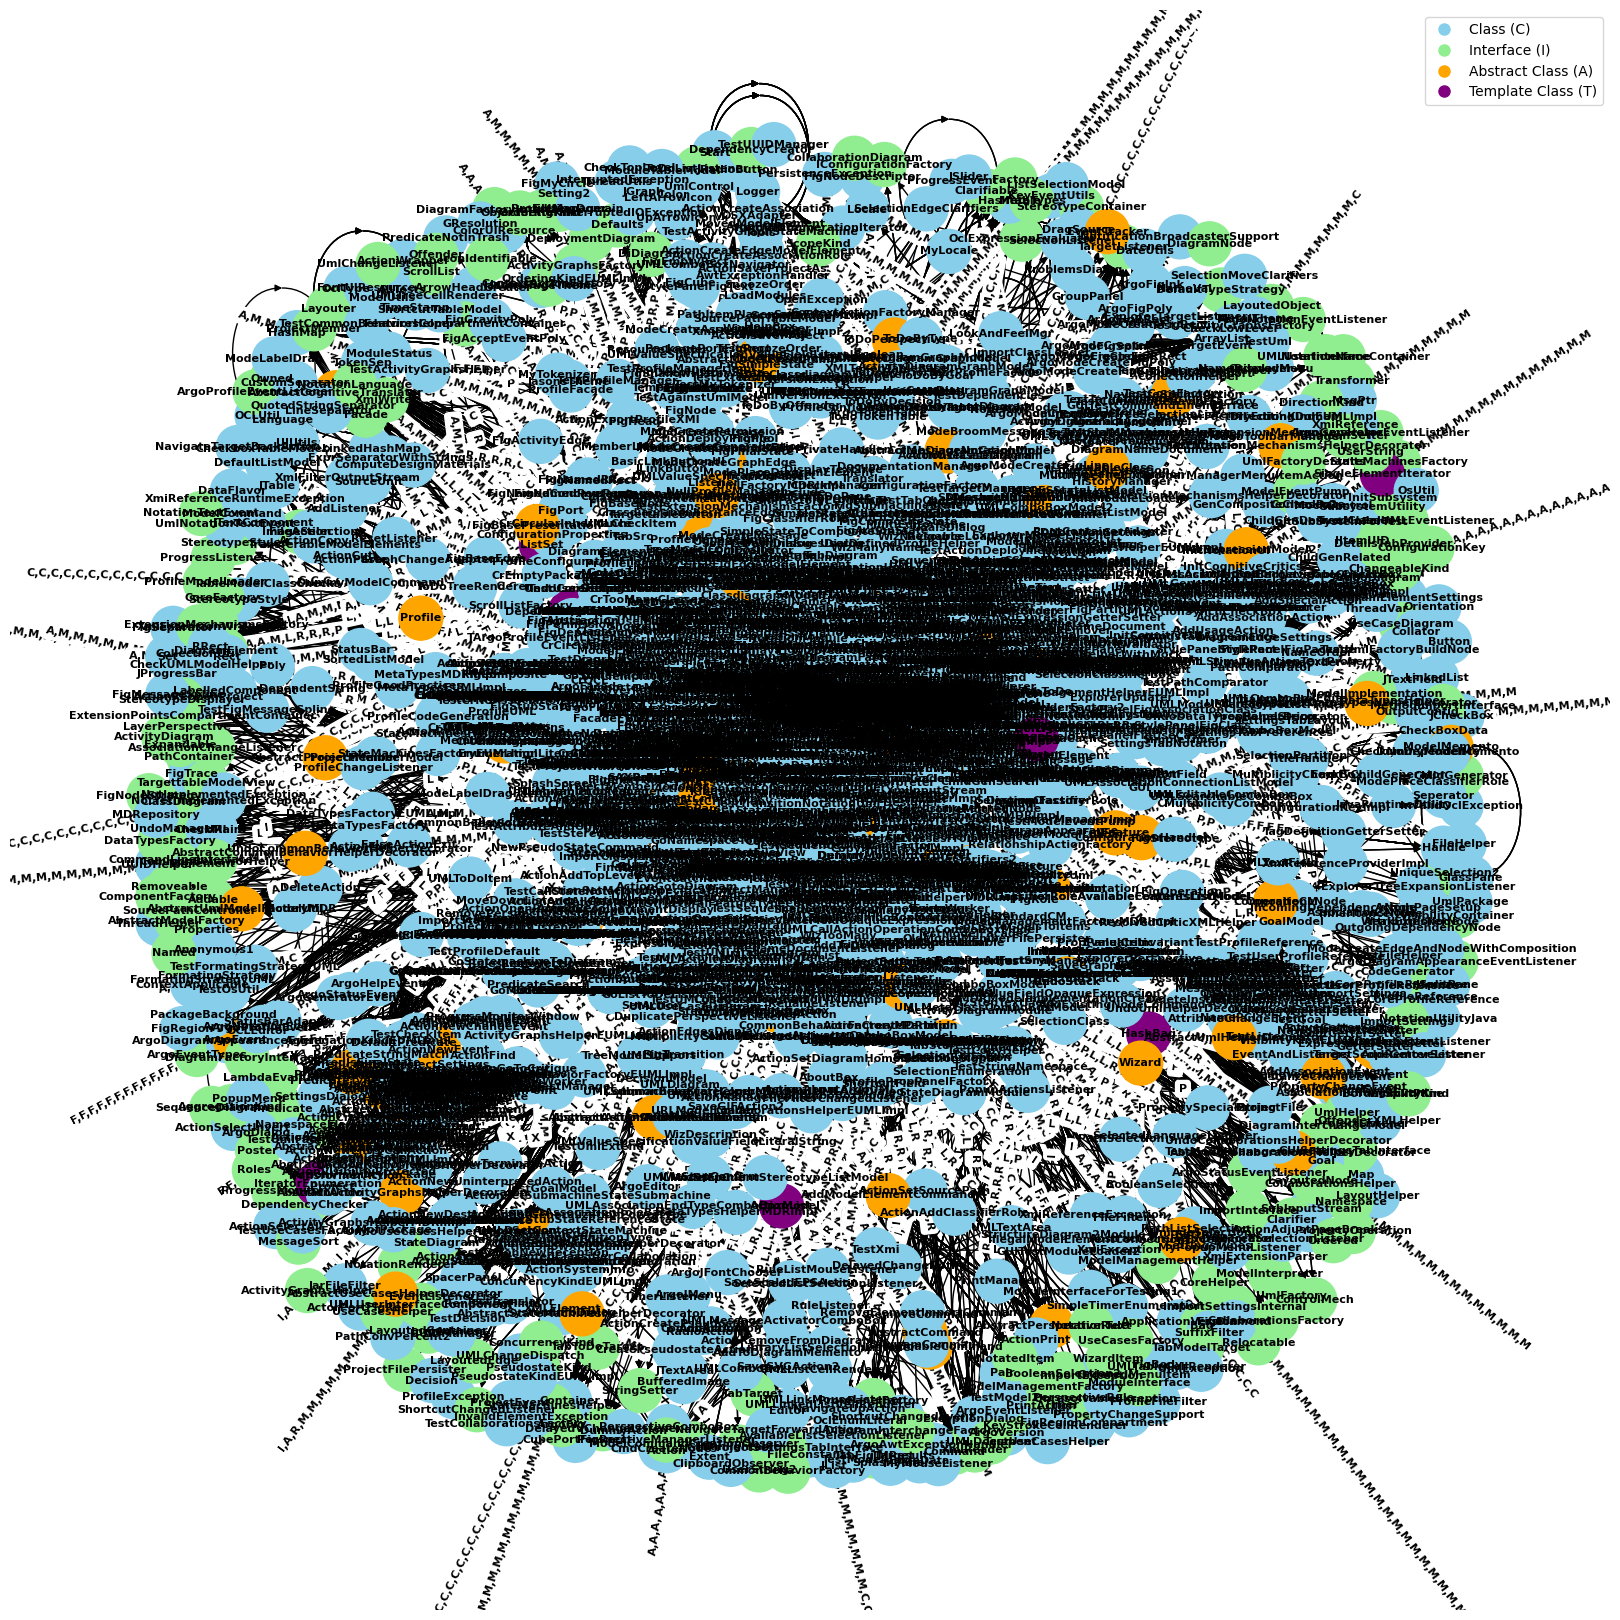

In [ ]:
visualize_graph(class_dependency_graph)

# Feature extraction

In [ ]:
import pandas as pd

def load_data(file_path):
    data = pd.read_csv(file_path, sep='\t')
    return data

def remove_empty_rows(data):
    data = data.dropna(subset=['CBO'])
    return data

def remove_unnamed_columns(data):
    data = data.filter(regex='^(?!Unnamed.*)')
    return data

dataset = load_data('/content/drive/MyDrive/Colab Notebooks/input/dataset.csv')
#data = load_data('dataset_jfreechart.csv')
#data = load_data('dataset_argouml.csv')
#data = load_data('dataset_xerces.csv')
dataset = remove_empty_rows(dataset)
dataset = remove_unnamed_columns(dataset)

In [ ]:
def convert_ordinal_to_numerical(data):
    ordinal_mapping = {
        'low': 1,
        'low-medium': 2,
        'medium-high': 3,
        'high': 4,
        'very-high': 5
    }
    columns_to_convert = ['Complexity', 'Coupling', 'Size', 'Lack of Cohesion']
    for column in columns_to_convert:
        data[column] = data[column].replace(ordinal_mapping)
    return data

dataset = convert_ordinal_to_numerical(dataset)

In [ ]:
def label_god_class(row, complexity_threshold=2, size_threshold=2):
    if row['Complexity'] > complexity_threshold and row['Size'] > size_threshold:
        return 1
    else:
        return 0

# Label the dataset
dataset['is_god_class'] = dataset.apply(label_god_class, axis=1)

# Count the number of God Classes
num_god_classes = dataset['is_god_class'].sum()
print(f'Number of God Classes in the dataset: {num_god_classes}')

Number of God Classes in the dataset: 0


In [ ]:
dataset.head()

QualifiedName              Name  Complexity  \
2                     com.iluwatar.eda.App               App           1   
4     com.iluwatar.eda.event.AbstractEvent     AbstractEvent           1   
5  com.iluwatar.eda.event.UserCreatedEvent  UserCreatedEvent           2   
6  com.iluwatar.eda.event.UserUpdatedEvent  UserUpdatedEvent           2   
8         com.iluwatar.eda.framework.Event             Event           1   

   Coupling  Size  Lack of Cohesion  CBO  RFC  SRFC  DIT  ...  NOSF  NOM  \
2         2     1                 1  6.0  7.0   2.0  1.0  ...   0.0  0.0   
4         1     1                 1  0.0  2.0   1.0  1.0  ...   0.0  1.0   
5         1     1                 1  1.0  0.0   0.0  2.0  ...   0.0  0.0   
6         1     1                 1  1.0  0.0   0.0  2.0  ...   0.0  0.0   
8         1     1                 1  0.0  1.0   0.0  1.0  ...   0.0  1.0   

   NOSM  NORM  LCOM  LCAM  LTCC  ATFD   SI  is_god_class  
2   1.0   0.0   0.0   0.0   0.0   0.0  0.0             0  
4   0.0   0.0   0.0   0.0   0.0   0.0  0.0             0  
5   0.0   0.0   0.0   0.0   0.0   0.0  0.0             0  
6   0.0   0.0   0.0   0.0   0.0   0.0  0.0             0  
8   0.0   0.0   0.0   0.0   0.0   0.0  0.0             0  

[5 rows x 25 columns]

In [ ]:
def add_features_to_nodes(graph, dataset):
    for node, data in graph.nodes(data=True):
        selected_row = dataset[dataset["Name"] == node]
        if selected_row.shape[0] > 0:
          data["Complexity"] = selected_row["Complexity"].iloc[0]
          data["Coupling"] = selected_row["Coupling"].iloc[0]
          data["Size"] = selected_row["Size"].iloc[0]
          data["Lack of Cohesion"] = selected_row["Lack of Cohesion"].iloc[0]
          data["is_god_class"] = selected_row['is_god_class'].iloc[0]
        else:
          data["Complexity"] = 0
          data["Coupling"] = 0
          data["Size"] = 0
          data["Lack of Cohesion"] = 0
          data["is_god_class"] = 0

def print_nodes_and_edges_with_data(graph):
    for node, data in graph.nodes(data=True):
        print(f"Node: {node} => Data: {data}")
        edges = list(graph.edges(node, data=True))
        if edges:
            print("Edges:")
            for source, target, data in edges:
                label = data['edge_type']
                print(f"  {source} --({label})--> {target}")
        else:
            print("No edges")
        print()

add_features_to_nodes(class_dependency_graph, dataset)
print_nodes_and_edges_with_data(class_dependency_graph)

Node: App => Data: {'class_type': 'C', 'weight': 1, 'Complexity': 1, 'Coupling': 2, 'Size': 1, 'Lack of Cohesion': 1, 'is_god_class': 0}
Edges:
  App --(C)--> EventDispatcher
  App --(C)--> UserCreatedEventHandler
  App --(C)--> UserUpdatedEventHandler
  App --(C)--> User
  App --(C)--> UserCreatedEvent
  App --(C)--> UserUpdatedEvent

Node: EventDispatcher => Data: {'class_type': 'C', 'weight': 1, 'Complexity': 1, 'Coupling': 1, 'Size': 1, 'Lack of Cohesion': 1, 'is_god_class': 0}
Edges:
  EventDispatcher --(A)--> Map
  EventDispatcher --(M)--> Map
  EventDispatcher --(M)--> Map
  EventDispatcher --(P)--> Handler

Node: UserCreatedEventHandler => Data: {'class_type': 'C', 'weight': 1, 'Complexity': 1, 'Coupling': 1, 'Size': 1, 'Lack of Cohesion': 1, 'is_god_class': 0}
Edges:
  UserCreatedEventHandler --(I)--> Handler
  UserCreatedEventHandler --(P)--> UserCreatedEvent

Node: UserUpdatedEventHandler => Data: {'class_type': 'C', 'weight': 1, 'Complexity': 1, 'Coupling': 1, 'Size': 1, 'L

# Design a GNN model

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 64.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from torch_geometric.data import Data

def convert_node_attributes_to_tensors(graph):
    # Convert node features and labels to tensors
    node_features_list = []
    node_labels_list = []
    node_mapping = {}
    node_index = 0

    for node, attributes in graph.nodes(data=True):
        node_features_list.append([
            attributes['Complexity'],
            attributes['Coupling'],
            attributes['Size'],
            attributes['Lack of Cohesion']
        ])
        node_labels_list.append(attributes['is_god_class'])
        node_mapping[node] = node_index
        node_index += 1

    node_features = torch.tensor(node_features_list, dtype=torch.float)
    node_labels = torch.tensor(node_labels_list, dtype=torch.long)

    # Normalize the features (optional but recommended)
    node_features = (node_features - node_features.mean(dim=0)) / node_features.std(dim=0)

    # Create edge index tensor
    edge_index_list = []
    for src, dest, _ in graph.edges(data=True):
        src_idx = node_mapping[src]
        dest_idx = node_mapping[dest]
        edge_index_list.append([src_idx, dest_idx])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

    return node_features, node_labels, edge_index

def networkx_to_pyg_data(graph):
    node_features, node_labels, edge_index = convert_node_attributes_to_tensors(class_dependency_graph)
    pyg_data = Data(x=node_features, y=node_labels, edge_index=edge_index)
    return pyg_data

In [ ]:
pyg_data = networkx_to_pyg_data(class_dependency_graph)

In [ ]:
print(f'Dataset: {pyg_data}:')
print('======================')
print(f'Number of graphs: {len(pyg_data)}')
print(f'Number of features: {pyg_data.num_features}')
print(f'Number of classes: {pyg_data.num_classes}')

Dataset: Data(x=[11, 4], edge_index=[2, 19], y=[11]):
Number of graphs: 3
Number of features: 4


AttributeError: ignored

In [ ]:
data = pyg_data  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
#print(f'Number of training nodes: {data.train_mask.sum()}')
#print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[11, 4], edge_index=[2, 19], y=[11])
Number of nodes: 11
Number of edges: 19
Average node degree: 1.73


AttributeError: ignored

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 1,  9],
        [ 1,  9],
        [ 1,  9],
        [ 1,  7],
        [ 2,  7],
        [ 2,  5],
        [ 3,  7],
        [ 3,  6],
        [ 5, 10],
        [ 5,  4],
        [ 6, 10],
        [ 6,  4],
        [10,  8]])


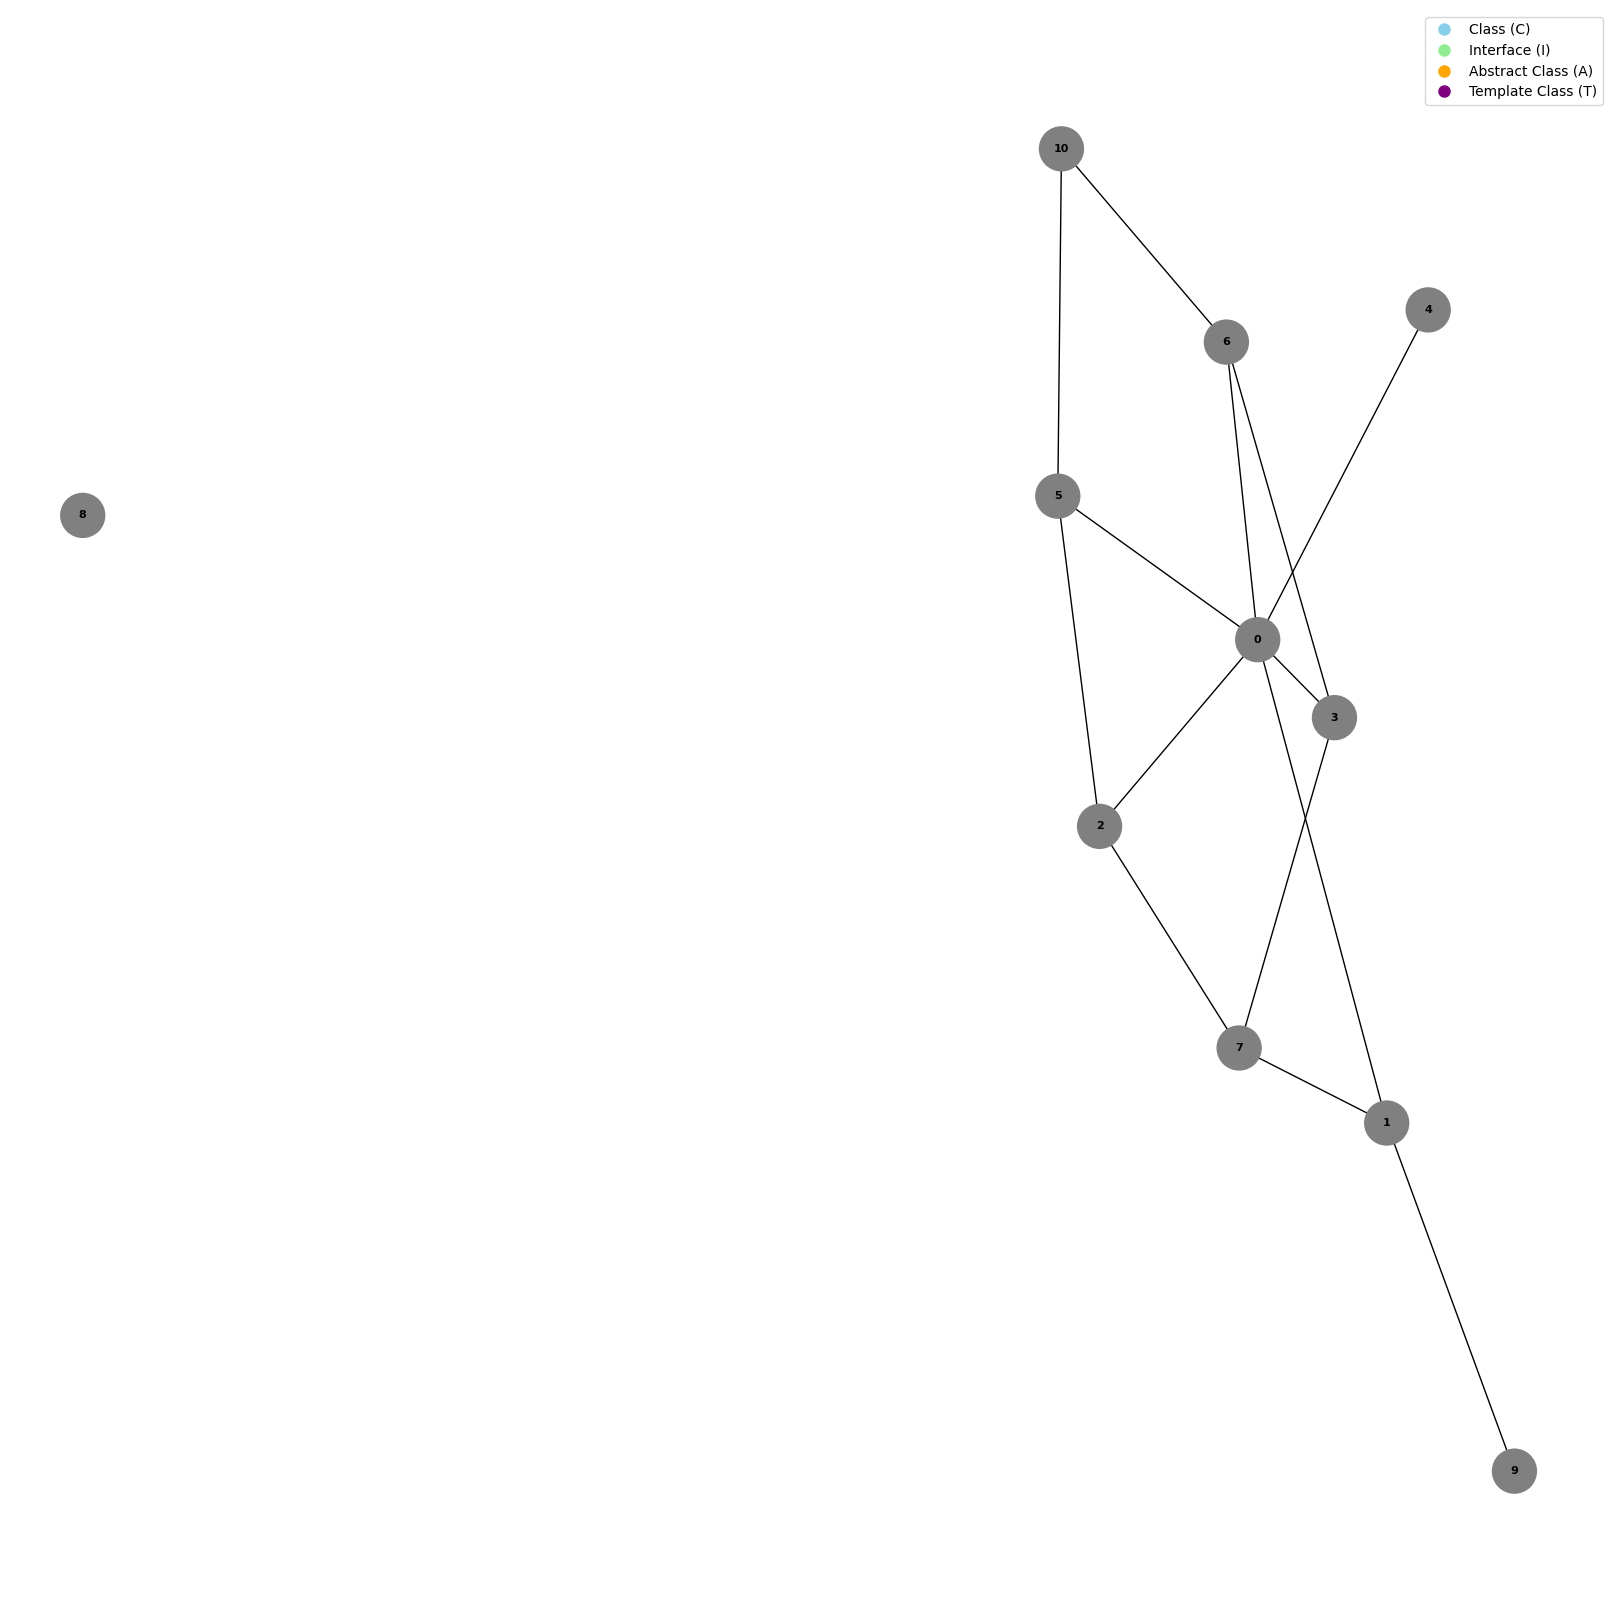

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G)

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, num_node_features=3, hidden_channels=16, num_classes=2):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(num_node_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP()
print(model)

MLP(
  (lin1): Linear(in_features=3, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GNNModel(torch.nn.Module):
    def __init__(self, num_node_features=3, hidden_channels=32, num_classes=2):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x


# Training and evaluation

In [ ]:
import torch
from torch_geometric.data import Data

def create_gnn_dataset(synthetic_dataset):
    gnn_dataset = []

    for project_name in synthetic_dataset['project_name'].unique():
        project_data = synthetic_dataset[synthetic_dataset['project_name'] == project_name]
        num_nodes = len(project_data)

        # Create node features with the columns "lines_of_code", "num_methods", and "cyclomatic_complexity"
        node_features = torch.tensor(project_data[["lines_of_code", "num_methods", "cyclomatic_complexity"]].values, dtype=torch.float)

        # Create a fully connected graph as there is no explicit relationship between classes
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t().contiguous()

        # Create target labels
        labels = torch.tensor(project_data["label"].values, dtype=torch.long)

        data = Data(x=node_features, edge_index=edge_index, y=labels)
        gnn_dataset.append(data)

    return gnn_dataset

gnn_dataset = create_gnn_dataset(synthetic_dataset)


In [ ]:
from sklearn.model_selection import train_test_split

def split_gnn_dataset(gnn_dataset, train_ratio=0.7, val_ratio=0.15):
    assert train_ratio + val_ratio < 1.0, "train_ratio and val_ratio should sum to less than 1.0"

    num_samples = len(gnn_dataset)
    train_size = int(train_ratio * num_samples)
    val_size = int(val_ratio * num_samples)

    # Shuffle the dataset
    indices = torch.randperm(num_samples)

    # Split the dataset
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    train_dataset = [gnn_dataset[i] for i in train_indices]
    val_dataset = [gnn_dataset[i] for i in val_indices]
    test_dataset = [gnn_dataset[i] for i in test_indices]

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_gnn_dataset(gnn_dataset)

In [ ]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, shuffle=True)
val_loader = DataLoader(val_dataset, shuffle=False)
test_loader = DataLoader(test_dataset, shuffle=False)

/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
model = MLP()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for data in data_loader:
        optimizer.zero_grad()
        out = model(data.x)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)


def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data in data_loader:
            out = model(data.x)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())

    return total_loss / len(data_loader), correct / len(data_loader.dataset)

num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Evaluate the model on the test dataset
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/100, Train Loss: 40.3285, Val Loss: 7.6375, Val Acc: 37.0000
Epoch 2/100, Train Loss: 17.2821, Val Loss: 1.0074, Val Acc: 26.0000
Epoch 3/100, Train Loss: 7.0262, Val Loss: 3.0065, Val Acc: 37.0000
Epoch 4/100, Train Loss: 3.8356, Val Loss: 0.7411, Val Acc: 37.0000
Epoch 5/100, Train Loss: 3.3410, Val Loss: 1.3176, Val Acc: 37.0000
Epoch 6/100, Train Loss: 1.1908, Val Loss: 0.6520, Val Acc: 37.0000
Epoch 7/100, Train Loss: 1.6020, Val Loss: 1.2602, Val Acc: 37.0000
Epoch 8/100, Train Loss: 1.1358, Val Loss: 0.7202, Val Acc: 37.0000
Epoch 9/100, Train Loss: 0.9110, Val Loss: 0.5433, Val Acc: 37.0000
Epoch 10/100, Train Loss: 0.8106, Val Loss: 0.5268, Val Acc: 37.0000
Epoch 11/100, Train Loss: 0.6737, Val Loss: 0.7294, Val Acc: 37.0000
Epoch 12/100, Train Loss: 0.7148, Val Loss: 0.5534, Val Acc: 37.0000
Epoch 13/100, Train Loss: 0.6915, Val Loss: 0.5028, Val Acc: 37.0000
Epoch 14/100, Train Loss: 0.6483, Val Loss: 0.5035, Val Acc: 37.0000
Epoch 15/100, Train Loss: 0.6964, Val Los

In [ ]:
import torch.nn as nn
import torch.optim as optim

class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = nn.ReLU()(self.layer1(x))
        x = nn.ReLU()(self.layer2(x))
        x = self.layer3(x)
        return x

input_dim = 3     # Number of features per node (e.g., lines of code, number of methods, etc.)
hidden_dim = 16   # Number of hidden channels in the GCN layers
output_dim = 2    # Number of output classes (0 for non-God class, 1 for God class)
mlp_model = MLPModel(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def mlp_train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def mlp_evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in val_loader:
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
    return total_loss / len(val_loader), correct / len(val_loader.dataset)

num_epochs = 100
for epoch in range(num_epochs):
    train_loss = mlp_train(mlp_model, train_loader, optimizer, criterion)
    val_loss, val_acc = mlp_evaluate(mlp_model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Evaluate on the test set
test_loss, test_acc = mlp_evaluate(mlp_model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


ValueError: ignored

In [ ]:
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for data in data_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        print(f"out shape: {out.shape}, target shape: {data.y.shape}")  # Debugging line
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)


def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data in data_loader:
            out = model(data.x, data.edge_index, data.batch)
            print(f"out shape: {out.shape}, target shape: {data.y.shape}")  # Debugging line
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())

    return total_loss / len(data_loader), correct / len(data_loader.dataset)



In [ ]:
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data in data_loader:
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += pred.eq(data.y).sum().item()

    return total_loss / len(data_loader), correct / len(data_loader.dataset)


# Interpretability and explainability

# Validation and testing

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 50

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Evaluate the model on the test dataset
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


out shape: torch.Size([7, 2]), target shape: torch.Size([350])


ValueError: ignored

In [ ]:
from sklearn.metrics import classification_report

print("Training classification report:")
print(classification_report(train_targets, train_predictions > 0.5))

print("Testing classification report:")
print(classification_report(test_targets, test_predictions > 0.5))


Training classification report:


NameError: ignored

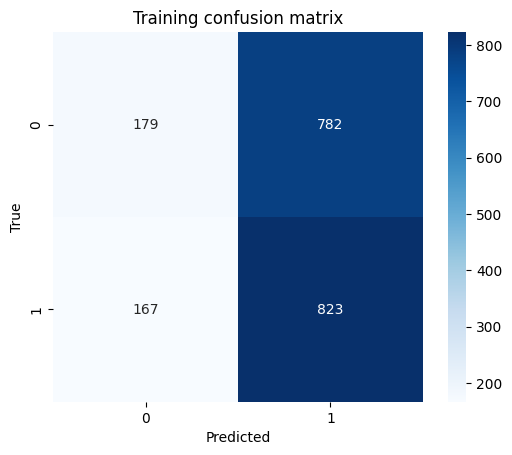

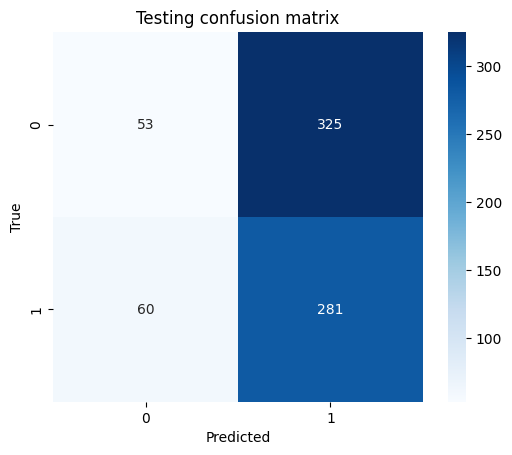

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(train_targets, train_predictions > 0.5)
test_cm = confusion_matrix(test_targets, test_predictions > 0.5)

sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.title("Training confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.title("Testing confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
